### Tutorial 3: Fast Ergodic Search with Kernel Functions

References:

[1] *Sun, M., Gaggar, A., Trautman, P. and Murphey, T.*, 2024. **Fast Ergodic Search with Kernel Functions**. arXiv preprint arXiv:2403.01536. [[Link](https://arxiv.org/abs/2403.01536)]

*(This tutorial will use JAX for auto-differentiation and accelerated computation.)*

In [129]:
import numpy as np 
np.set_printoptions(precision=4)
from tqdm import tqdm

import jax
import jax.numpy as jnp 
from jax import jit, vmap, grad
from jax.scipy.stats import multivariate_normal as mvn

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

#### Kernel ergodic metric

Recall that the original ergodic metric is defined as:

$$
\mathcal{E}(p(x), s(t)) = \sum_{k} \lambda_k \cdot (c_k - \phi_k)^2
$$

where

$$
\begin{aligned}
    \phi_k = \int_{\mathcal{X}} f_k(x) p(x) dx, \quad c_k = \frac{1}{T} \int_{0}^{T} f_k(s(t)) dt
\end{aligned}
$$

Here we introduce another formula for the ergodic metric, named the *kernel ergodic metric*:

$$
\mathcal{E}_g(p(x), s(t)) = \frac{1}{T} \int_{0}^{T} p(s(t)) dt - \frac{2}{T^2} \int_{0}^{T} \int_{0}^{T} g(s(t), s(\tau); \theta) dt d\tau
$$

where $g(s, s^\prime)$ is a kernel function that can asymptotically converge to a Dirac delta function. In practice, it is often modeled as a squared exponential (Gaussian) kernel:

$$
\Lambda(s, s^\prime; \theta) = \mathcal{N}(s \vert s^\prime, \theta)
$$

where the parameter $theta$ serves as the covariance of the Gaussian.

For each spatial probability distribution $p(x)$, there exists a parameter $\theta$ such that the kernel function $g(\cdot, \cdot ; \theta)$ such that optimizing the original ergodic metric and optimizing the kernel ergodic metric converge to the same trajectory. Furthermore, such a parameter $\theta$ can be solved through the following optimization problem:

$$
\begin{align}
    \theta^* & = {\arg\min}_{\theta} \left\vert \frac{d}{d\theta} \left( \frac{1}{N}\sum_{i=1}^{N} p(x_i) - \frac{2}{N^2} \sum_{i=0}^{N} \sum_{j=0}^{N} g(x_i, x_j; \theta) \right) \right\vert^2, \quad \{x_i\}_N \sim p(x)
\end{align}
$$

where each $x_i$ is a sample from the spatial probability distribution $p(x)$. 

In [130]:
# Define a Gaussian-mixture spatial distribution
mean1 = jnp.array([0.35, 0.38])
cov1 = jnp.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.5

mean2 = jnp.array([0.68, 0.25])
cov2 = jnp.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = jnp.array([0.56, 0.64])
cov3 = jnp.array([
    [0.008, 0.0],
    [0.0, 0.004]
])
w3 = 0.3


@jit
def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3)

d_pdf = jit(grad(pdf))


# Sample from the spatial distribution
rng = jax.random.PRNGKey(12)
num_samples = 100
target_samples = jnp.vstack([
    jax.random.multivariate_normal(rng, mean=mean1, cov=cov1, shape=(int(num_samples*w1),)),
    jax.random.multivariate_normal(rng, mean=mean2, cov=cov2, shape=(int(num_samples*w2),)),
    jax.random.multivariate_normal(rng, mean=mean3, cov=cov3, shape=(int(num_samples*w3),))
])


# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], 100),
    np.linspace(0, L_list[1], 100)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / 99
dy = 1.0 / 99 

pdf_vals = pdf(grids)

In [131]:
# Define the kernel function (we use the exponential formula for better numerical stability)
@jit 
def kernel(x1, x2, theta):
    return mvn.pdf(x=x1, mean=x2, cov=jnp.diag(jnp.power(10.0, theta)))

d2_kernel = jit(grad(kernel, argnums=(1)))

# Define the kernel ergdic metric over samples
def samples_kernel_metric(theta, samples):
    val1 = vmap(pdf, in_axes=(0,))(samples)
    val2 = vmap(vmap(kernel, in_axes=(0,None,None)), in_axes=(None,0,None))(samples, samples, theta)
    return -2.0 * jnp.mean(val1) + jnp.mean(val2)

grad_samples_kernel_metric = grad(samples_kernel_metric, argnums=(1))


# Define the objective for optimizing kernel parameters
# @jit 
def parameter_opt_obj(theta, samples):
    dvec = grad_samples_kernel_metric(theta, samples)
    return jnp.sum(jnp.square(dvec))  

# Gradient of the objective
grad_parameter_opt_obj = jit(grad(parameter_opt_obj, argnums=(0)))

test_theta = jnp.array([-3.0, -3.0])
print('kernel parameter obj: ', parameter_opt_obj(test_theta, target_samples))
print('kernel parameter obj grad: ', grad_parameter_opt_obj(test_theta, target_samples))

kernel parameter obj:  166.76172
kernel parameter obj grad:  [-325.5596 -350.9618]


In [132]:
# Optimize the kernel parameter
from jax.scipy.optimize import minimize 

sol = minimize(parameter_opt_obj, x0=test_theta, args=(target_samples,), method='bfgs')
opt_theta = sol.x
# opt_theta = jnp.ones(2) * jnp.log10(1.0 / 520.0)
print('optimal kernel parameter: ', opt_theta)

optimal kernel parameter:  [-2.4577 -2.5869]


We can apply the same iLQR trajectory optimization method for the kernel ergodic metric. The difference from the original ergodic metric is:

$$
a(t) = -\frac{2}{T} \nabla p(x(t)) + \frac{2}{T^2} \int_{0}^{T} \nabla g(x(t), x(\tau)) d\tau
$$

We now verify the trajectory optimization result on the kernel ergodic metric below.

In [133]:
class iLQR_template:
    def __init__(self, dt, tsteps, x_dim, u_dim, Q_z, R_v) -> None:
        self.dt = dt 
        self.tsteps = tsteps 

        self.x_dim = x_dim 
        self.u_dim = u_dim

        self.Q_z = Q_z 
        self.Q_z_inv = np.linalg.inv(Q_z)
        self.R_v = R_v 
        self.R_v_inv = np.linalg.inv(R_v)

        self.curr_x_traj = None 
        self.curr_y_traj = None

    def dyn(self, xt, ut):
        raise NotImplementedError("Not implemented.")

    def step(self, xt, ut): 
        """RK4 integration"""
        k1 = self.dt * self.dyn(xt, ut)
        k2 = self.dt * self.dyn(xt + k1/2.0, ut)
        k3 = self.dt * self.dyn(xt + k2/2.0, ut)
        k4 = self.dt * self.dyn(xt + k3, ut)

        xt_new = xt + (k1 + 2.0*k2 + 2.0*k3 + k4) / 6.0 
        return xt_new 
    
    def traj_sim(self, x0, u_traj):
        x_traj = np.zeros((self.tsteps, self.x_dim))
        xt = x0.copy()
        for t_idx in range(self.tsteps):
            xt = self.step(xt, u_traj[t_idx])
            x_traj[t_idx] = xt.copy()
        return x_traj
    
    def loss(self):
        raise NotImplementedError("Not implemented.")
    
    def get_At_mat(self, t_idx):
        raise NotImplementedError("Not implemented.")
    
    def get_Bt_mat(self, t_idx):
        raise NotImplementedError("Not implemented.")

    def get_at_vec(self, t_idx):
        raise NotImplementedError("Not implemented.")
    
    def get_bt_vec(self, t_idx):
        raise NotImplementedError("Not implemented.")

    # the following functions are utilities for solving the Riccati equation
    def P_dyn_rev(self, Pt, At, Bt, at, bt):
        return Pt @ At + At.T @ Pt - Pt @ Bt @ self.R_v_inv @ Bt.T @ Pt + self.Q_z 
    
    def P_dyn_step(self, Pt, At, Bt, at, bt):
        k1 = self.dt * self.P_dyn_rev(Pt, At, Bt, at, bt)
        k2 = self.dt * self.P_dyn_rev(Pt+k1/2, At, Bt, at, bt)
        k3 = self.dt * self.P_dyn_rev(Pt+k2/2, At, Bt, at, bt)
        k4 = self.dt * self.P_dyn_rev(Pt+k3, At, Bt, at, bt)

        Pt_new = Pt + (k1 + 2.0*k2 + 2.0*k3 + k4) / 6.0 
        return Pt_new 
    
    def P_traj_revsim(self, PT, A_traj, B_traj, a_traj, b_traj):
        P_traj_rev = np.zeros((self.tsteps, self.x_dim, self.x_dim))
        P_curr = PT.copy()
        for t in range(self.tsteps):
            At = A_traj[-1-t]
            Bt = B_traj[-1-t]
            at = a_traj[-1-t]
            bt = b_traj[-1-t]

            P_new = self.P_dyn_step(P_curr, At, Bt, at, bt)
            P_traj_rev[t] = P_new.copy()
            P_curr = P_new 
        
        return P_traj_rev

    def r_dyn_rev(self, rt, Pt, At, Bt, at, bt):
        return (At - Bt @ self.R_v_inv @ Bt.T @ Pt).T @ rt + at - Pt @ Bt @ self.R_v_inv @ bt

    def r_dyn_step(self, rt, Pt, At, Bt, at, bt):
        k1 = self.dt * self.r_dyn_rev(rt, Pt, At, Bt, at, bt)
        k2 = self.dt * self.r_dyn_rev(rt+k1/2, Pt, At, Bt, at, bt)
        k3 = self.dt * self.r_dyn_rev(rt+k2/2, Pt, At, Bt, at, bt)
        k4 = self.dt * self.r_dyn_rev(rt+k3, Pt, At, Bt, at, bt)

        rt_new = rt + (k1 + 2.0*k2 + 2.0*k3 + k4) / 6.0 
        return rt_new
    
    def r_traj_revsim(self, rT, P_traj, A_traj, B_traj, a_traj, b_traj):
        r_traj_rev = np.zeros((self.tsteps, self.x_dim))
        r_curr = rT
        for t in range(self.tsteps):
            Pt = P_traj[-1-t]
            At = A_traj[-1-t]
            Bt = B_traj[-1-t]
            at = a_traj[-1-t]
            bt = b_traj[-1-t]

            r_new = self.r_dyn_step(r_curr, Pt, At, Bt, at, bt)
            r_traj_rev[t] = r_new.copy()
            r_curr = r_new 

        return r_traj_rev

    def z_dyn(self, zt, Pt, rt, At, Bt, bt):
        return At @ zt + Bt @ self.z2v(zt, Pt, rt, Bt, bt)
    
    def z_dyn_step(self, zt, Pt, rt, At, Bt, bt):
        k1 = self.dt * self.z_dyn(zt, Pt, rt, At, Bt, bt)
        k2 = self.dt * self.z_dyn(zt+k1/2, Pt, rt, At, Bt, bt)
        k3 = self.dt * self.z_dyn(zt+k2/2, Pt, rt, At, Bt, bt)
        k4 = self.dt * self.z_dyn(zt+k3, Pt, rt, At, Bt, bt)

        zt_new = zt + (k1 + 2.0*k2 + 2.0*k3 + k4) / 6.0 
        return zt_new

    def z_traj_sim(self, z0, P_traj, r_traj, A_traj, B_traj, b_traj):
        z_traj = np.zeros((self.tsteps, self.x_dim))
        z_curr = z0.copy()

        for t in range(self.tsteps):
            Pt = P_traj[t]
            rt = r_traj[t]
            At = A_traj[t]
            Bt = B_traj[t]
            bt = b_traj[t]

            z_new = self.z_dyn_step(z_curr, Pt, rt, At, Bt, bt)
            z_traj[t] = z_new.copy()
            z_curr = z_new
        
        return z_traj
    
    def z2v(self, zt, Pt, rt, Bt, bt):
        return -self.R_v_inv @ Bt.T @ Pt @ zt - self.R_v_inv @ Bt.T @ rt - self.R_v_inv @ bt

    def get_descent(self, x0, u_traj):
        # forward simulate the trajectory
        x_traj = self.traj_sim(x0, u_traj)
        self.curr_x_traj = x_traj.copy()
        self.curr_u_traj = u_traj.copy()

        # sovle the Riccati equation backward in time
        A_traj = np.zeros((self.tsteps, self.x_dim, self.x_dim))
        B_traj = np.zeros((self.tsteps, self.x_dim, self.u_dim))
        a_traj = np.zeros((self.tsteps, self.x_dim))
        b_traj = np.zeros((self.tsteps, self.u_dim))

        for t_idx in range(self.tsteps):
            A_traj[t_idx] = self.get_At_mat(t_idx)
            B_traj[t_idx] = self.get_Bt_mat(t_idx)
            a_traj[t_idx] = self.get_at_vec(t_idx)
            b_traj[t_idx] = self.get_bt_vec(t_idx)

        # print('a_traj:\n', a_traj)
        
        PT = np.zeros((self.x_dim, self.x_dim))
        P_traj_rev = self.P_traj_revsim(PT, A_traj, B_traj, a_traj, b_traj)
        P_traj = np.flip(P_traj_rev, axis=0)

        rT = np.zeros(self.x_dim)
        r_traj_rev = self.r_traj_revsim(rT, P_traj, A_traj, B_traj, a_traj, b_traj)
        r_traj = np.flip(r_traj_rev, axis=0)

        z0 = np.zeros(self.x_dim)
        z_traj = self.z_traj_sim(z0, P_traj, r_traj, A_traj, B_traj, b_traj)

        # compute the descent direction
        v_traj = np.zeros((self.tsteps, self.u_dim))
        for t in range(self.tsteps):
            zt = z_traj[t]
            Pt = P_traj[t]
            rt = r_traj[t]
            Bt = B_traj[t]
            bt = b_traj[t]
            v_traj[t] = self.z2v(zt, Pt, rt, Bt, bt)
        
        return v_traj

In [134]:
class iLQR_kernel_ergodic_pointmass(iLQR_template):
    def __init__(self, dt, tsteps, x_dim, u_dim, Q_z, R_v,
                 R, kernel_theta) -> None:
        super().__init__(dt, tsteps, x_dim, u_dim, Q_z, R_v)
        
        self.R = R 
        self.kernel_theta = jnp.array(kernel_theta)
        

    def dyn(self, xt, ut):
        return ut
        
    def get_At_mat(self, t_idx):
        A = np.zeros((self.x_dim, self.x_dim))
        return A
    
    def get_Bt_mat(self, t_idx):
        B = np.eye(self.u_dim)
        return B

    def get_at_vec(self, t_idx):
        xt = jnp.array(self.curr_x_traj[t_idx][:2])
        x_traj = jnp.array(self.curr_x_traj[:,:2])
        
        d_pdf_xt = np.array(d_pdf(xt))
        d_kernel_traj = vmap(d2_kernel, in_axes=(0,None,None))(x_traj, xt, self.kernel_theta)
        d_kernel_traj = np.array(d_kernel_traj)
        # print('d_kernel_traj.shape: ', d_kernel_traj.shape)

        T = self.tsteps * self.dt 
        at = -2.0 * d_pdf_xt / T + 2.0 * np.sum(d_kernel_traj, axis=0) * self.dt / (T*T)

        # print(t_idx, at, -2.0 * d_pdf_xt / T, 2.0 * np.sum(d_kernel_traj, axis=0) * self.dt / (T*T))

        return at

    def get_bt_vec(self, t_idx):
        ut = self.curr_u_traj[t_idx]
        return self.R @ ut 
    
    def loss(self, x_traj, u_traj):
        x_traj_jax = jnp.array(x_traj)
        T = self.dt * self.tsteps
        pdf_cost = jnp.sum(vmap(pdf, in_axes=(0,))(x_traj_jax)) * self.dt / T
        kernel_cost = vmap(vmap(kernel, in_axes=(0,None,None)), in_axes=(None,0,None))(x_traj_jax, x_traj_jax, self.kernel_theta)
        kernel_cost = jnp.sum(kernel_cost) * (self.dt * self.dt) / (T * T)
        erg_metric = -2.0 * pdf_cost + kernel_cost

        ctrl_cost = np.sum(self.R @ u_traj.T * u_traj.T) * self.dt 
        return erg_metric + ctrl_cost

In [135]:
# Define the optimal control problem 
dt = 0.1 
tsteps = 100
R = np.diag([1e-08, 1e-08])
Q_z = np.diag([0.01, 0.01]) * 10.0
R_v = np.diag([0.01, 0.01]) * 10.0
x0 = np.random.uniform(low=0.4, high=0.6, size=(2,))
# x0 = np.array([0.48, 0.52])

temp_x_traj = np.array([
    np.linspace(0.0, 0.3, tsteps+1) * np.cos(np.linspace(0.0, 2*np.pi, tsteps+1)),
    np.linspace(0.0, 0.3, tsteps+1) * np.sin(np.linspace(0.0, 2*np.pi, tsteps+1))
]).T
init_u_traj = (temp_x_traj[1:, :] - temp_x_traj[:-1, :]) / dt

In [136]:
trajopt_kernel_ergodic_pointmass = iLQR_kernel_ergodic_pointmass(
    dt, tsteps, x_dim=2, u_dim=2, Q_z=Q_z, R_v=R_v,
    R=R, kernel_theta=opt_theta
)

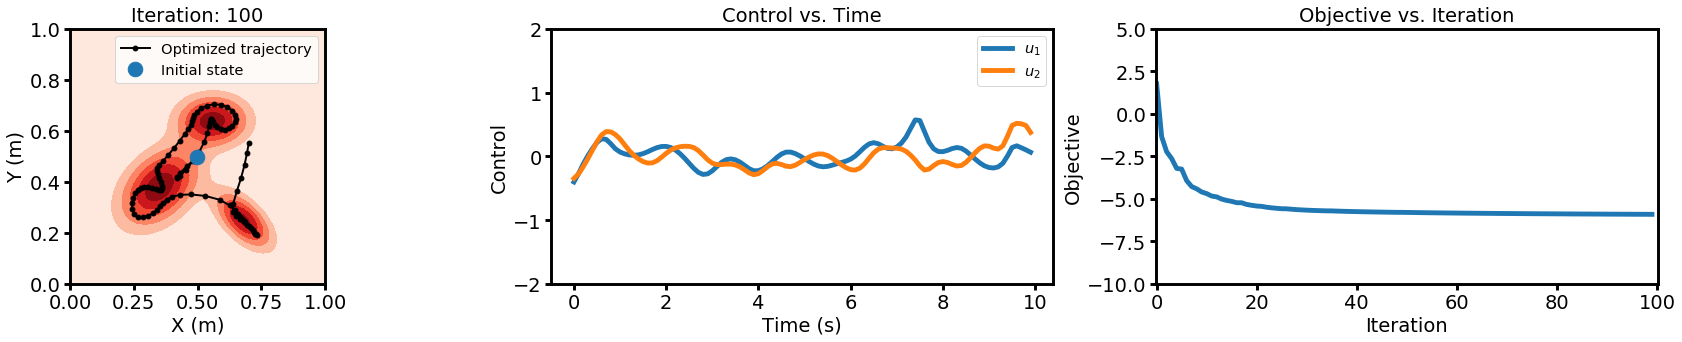

In [137]:
# Iterative trajectory optimization for ergodic control
from IPython import display

u_traj = init_u_traj.copy()
step = 0.01
loss_list = []

fig, axes = plt.subplots(1, 3, dpi=70, figsize=(25,5), tight_layout=True)

for iter in tqdm(range(100)):
    x_traj = trajopt_kernel_ergodic_pointmass.traj_sim(x0, u_traj)
    # print('x_traj:\n', x_traj)
    # print('u_traj:\n', u_traj)
    v_traj = trajopt_kernel_ergodic_pointmass.get_descent(x0, u_traj)

    loss_val = trajopt_kernel_ergodic_pointmass.loss(x_traj, u_traj)
    loss_list.append(loss_val)

    step = 0.002
    alpha = 0.5
    for _i in range(3):
        temp_u_traj = u_traj + step * v_traj
        temp_x_traj = trajopt_kernel_ergodic_pointmass.traj_sim(x0, temp_u_traj)
        temp_loss_val = trajopt_kernel_ergodic_pointmass.loss(temp_x_traj, temp_u_traj)
        if temp_loss_val < loss_val:
            break
        else:
            step *= alpha
    u_traj += step * v_traj

    # visualize every 10 iterations
    if (iter+1) % 10 == 0:
        ax1 = axes[0]
        ax1.cla()
        ax1.set_aspect('equal', adjustable='box')
        ax1.set_xlim(0.0, L_list[0])
        ax1.set_ylim(0.0, L_list[1])
        ax1.set_title('Iteration: {:d}'.format(iter+1))
        ax1.set_xlabel('X (m)')
        ax1.set_ylabel('Y (m)')
        ax1.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
        ax1.plot([x0[0], x_traj[0,0]], [x0[1], x_traj[0,1]], linestyle='-', linewidth=2, color='k', alpha=1.0)
        ax1.plot(x_traj[:,0], x_traj[:,1], linestyle='-', marker='o', color='k', linewidth=2, alpha=1.0, label='Optimized trajectory')
        ax1.plot(x0[0], x0[1], linestyle='', marker='o', markersize=15, color='C0', alpha=1.0, label='Initial state')
        ax1.legend(loc=1)

        ax2 = axes[1]
        ax2.cla()
        ax2.set_title('Control vs. Time')
        ax2.set_ylim(-2.0, 2.0)
        ax2.plot(np.arange(tsteps)*dt, u_traj[:,0], color='C0', label=r'$u_1$')
        ax2.plot(np.arange(tsteps)*dt, u_traj[:,1], color='C1', label=r'$u_2$')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Control')
        ax2.legend(loc=1)
        height = ax1.get_position().height
        ax2.set_position([ax2.get_position().x0, ax1.get_position().y0, ax2.get_position().width, height])

        ax3 = axes[2]
        ax3.cla()
        ax3.set_title('Objective vs. Iteration')
        ax3.set_xlim(-0.2, 100.2)
        ax3.set_ylim(-10.0, 5.0)
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Objective')
        ax3.plot(np.arange(iter+1), loss_list, color='C0')
        height = ax1.get_position().height
        ax3.set_position([ax3.get_position().x0, ax1.get_position().y0, ax3.get_position().width, height])
        # ax3.set_yscale('log')

        display.clear_output(wait=True)
        display.display(fig)

display.clear_output(wait=True)
plt.show()
plt.close()